# SAM for Surface
At this point, the fatigue fracture surface can be reasonably segmented from the surface. However, to actually use it as a predictor, we need to adjust the ammount of fatigue to total area, since the area the fracture surface takes up will vary from image to image

In [1]:
import os
import sys
import numpy as np
path = '/mnt/vstor/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman-2/topics/aml-fractography/sam'
sys.path.append(path)
from segment_anything import sam_model_registry, SamPredictor
import urllib.request

sam_checkpoint = path +"/sam_vit_h_4b8939.pth"
# url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
# sam_checkpoint = urllib.request.urlretrieve(url)

model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
import cv2
import pandas as pd
import math
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
#sys.path.append('/mnt/vstor/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman-2/packages/') #This was moved to the same repo
from organize_data import is_binary, size,size_red, is_greyscale, is_8bit, valid_image

#Define metric functions
def perimeter_coverage(mask):
    # Get the dimensions of the mask
    height, width = mask.shape
    mask = mask.astype(np.uint8)
    if(np.max(mask)!=255):
        mask = mask*255
    # Extract the perimeter: first and last rows, and first and last columns
    perimeter_pixels = np.concatenate([
        mask[0, :],  # Top row
        mask[-1, :],  # Bottom row
        mask[0:-1, 0],  # Left column
        mask[0:-1, -1]  # Right column
    ])
    if(mask.dtype==np.uint8):
        max_size=2**8 -1
    elif(mask.dtype==np.uint16):
        max_size=2**16 -1
    elif(mask.dtype==np.uint32):
        max_size=2**32 -1
    elif(mask.dtype==np.uint64):
        max_size=2**64 -1
    elif(mask.dtype==np.float16 or mask.dtype==np.float32 or mask.dtype==np.float64):
        max_size=2**32 -1
    else:
        raise TypeError('Mask must be an unsigned interger or float. Was type:'+str(mask.dtype))

    # Total perimeter pixels
    total_perimeter_pixels = len(perimeter_pixels)*max_size

    # Count how many of those pixels are part of the mask (assuming mask is binary 1/0)
    covered_perimeter_pixels = np.sum(perimeter_pixels)

    # Calculate the percentage of the perimeter covered by the mask
    coverage_ratio = covered_perimeter_pixels / total_perimeter_pixels if total_perimeter_pixels != 0 else 0

    return coverage_ratio

#From Claude 3.5 Connet Oct.24, 2024
def unfilled_ratio(img):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    # Apply threshold to get binary image
    _, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0
    
    # Find the largest contour (assuming it's the main object)
    main_contour = max(contours, key=cv2.contourArea)
    
    # Calculate total area within the outer contour
    total_area = cv2.contourArea(main_contour)

    # Calculate area of holes
    holes_area = 0
    print(len(contours))
    if hierarchy is not None:
        for i, h in enumerate(hierarchy[0]):
            # If this contour has a parent (meaning it's a hole)
            if h[3] >= 0:  # h[3] is the index of the parent contour
                holes_area += cv2.contourArea(contours[i])
    
    # Calculate ratio
    if total_area == 0:
        return 0
    print('total area: '+str(total_area))
    print('holes area: '+str(holes_area))
    unfilled_ratio = holes_area / total_area

    # # Create visualization
    # # visualization = img.copy()
    # Draw main contour in green
    # cv2.drawContours(visualization, [main_contour], -1, (0, 255, 0), 2)
    # # Draw holes in red
    # for i, h in enumerate(hierarchy[0]):
    #     if h[3] >= 0:  # If it's a hole
    #         cv2.drawContours(visualization, [contours[i]], -1, (0, 0, 255), 2)
    
    # Add text with measurements
    # cv2.putText(visualization, f'Total Area: {total_area:.0f}', (10, 30),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.putText(visualization, f'Holes Area: {holes_area:.0f}', (10, 60),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.putText(visualization, f'Ratio: {fill_ratio:.3f}', (10, 90),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.imshow('fill visualization',visualization)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return unfilled_ratio
def print_column_counts(df,example=0):
    row_structure = '|{:^50}|{:^10}|{:^10}|{:^10}|{:^15}|'
    print(row_structure.format('Column name', 'Nulls','Values','Position','Example'))
    i=0
    for column in df.columns:
        nas = df[column].isna().sum()
        print(row_structure.format(column,str(nas),str(len(df[column])-nas),str(i),str(df[column].iloc[example])[0:15]))
        i+=1

#Sorting Data
task = 'path_stitched'
combined_df = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv') # Loading combined_df
print_column_counts(combined_df)
combined_df = combined_df[-combined_df[task].isna()] # Filtering out those without the tasked image
combined_df = combined_df[~combined_df['Sample#'].str.contains('CMU11')] # Filtering out the unpolished samples
#combined_df = combined_df[-combined_df['MPa'].isna()&800>combined_df['MPa']] #Filtering out samples with very small defects
print_column_counts(combined_df)

def read_img(inp,column):
    input_df = pd.read_csv(inp.iloc[idx][column])
    path = input_df.iloc[0]['path']
    img = cv2.imread(path) #Read image, is color
    try:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #Convert to Greyscale, removing masks if present
    except cv2.error:
        pass #It throws a generic error
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) #Convert back to color
    print(path)
    print(inp.iloc[idx]['MPa'])
    return img

idx=0

organize_data
|                   Column name                    |  Nulls   |  Values  | Position |    Example    |
|                    Unnamed: 0                    |    0     |   940    |    0     |      46       |
|                     Sample#                      |    0     |   940    |    1     |   CMU1-3-2    |
|                     Build ID                     |   623    |   317    |    2     |     CMU01     |
|                     Build #                      |   623    |   317    |    3     |      3.0      |
|                      Test #                      |   623    |   317    |    4     |      2.0      |
|                      Retest                      |   577    |   363    |    5     |      2.0      |
|                   Project Name                   |   625    |   315    |    6     |      ULI      |
|                  Scan Power (W)                  |   577    |   363    |    7     |     370.0     |
|               Scan velocity (mm/s)               |   577    |   36

/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU02(PW)/CMU02-20/CMU2-20-2-Stitched.tif
nan


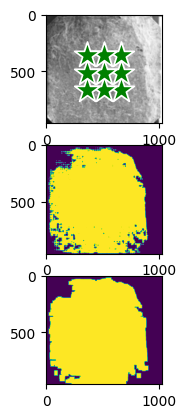

In [70]:
idx += 1
d_pos = .3
grid_spacing = 32
RANDOM_POSITIONS=20
task='path_stitched'
input_size = 1024

all_points = []
input_label = []
image = read_img(combined_df,task)
image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
if(input_size==1024):
    image = image[0:960,:]
    input_size = 960
image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
condition_img = image_blurred>253
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
#Remove reflective edges
condition_img = image_blurred>253
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
# if len(non_zero_indices[0]) > 0:
#     for i in range(RANDOM_POSITIONS):
#         temp_idx = int(random.random()*len(non_zero_indices[0]))
#         all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
#         input_label.append(0)

for x_pos in [len(image_blurred[0])*.65,len(image_blurred[0])*.5,len(image_blurred[0])*.35]:
    for y_pos in [len(image_blurred[1])*.65,len(image_blurred[0])*.5,len(image_blurred[1])*.35]:
        all_points.append([x_pos,y_pos])
        input_label.append(1)

predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=np.array(all_points),
    point_labels=np.array(input_label),
    multimask_output=False,
)
processed_mask = (masks[0]).astype(np.uint8) * 255

# Step 1: Label connected components
num_labels, labels_im = cv2.connectedComponents(processed_mask)

# Step 2: Count pixels for each label
sizes = np.bincount(labels_im.ravel())

# Step 3: Find the largest component (ignore the background)
largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

# Step 4: Create a new mask for the largest component
largest_defect_mask = np.zeros_like(processed_mask)
largest_defect_mask[labels_im == largest_component_label] = 255
processed_mask = largest_defect_mask
# Creating kernel 
dilate_kernel = np.ones((6, 6), np.uint8)
erosion_kernal = np.ones((6, 6), np.uint8)
# Using cv2.erode() method  
processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

# fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
def fill_mask_holes(mask):
    """
    Fill holes in a binary mask using floodFill.
    
    Parameters:
    mask (numpy.ndarray): Binary input mask (0 and 255 values)
    
    Returns:
    numpy.ndarray: Mask with holes filled
    """
    # Ensure mask is binary and of type uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Threshold to ensure binary image
    _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    
    # Create a copy of the mask for flood filling
    # Note: floodFill needs a mask that's 2 pixels bigger in each direction
    h, w = binary_mask.shape
    filled_mask = binary_mask.copy()
    filling_mask = np.zeros((h + 2, w + 2), np.uint8)
    
    # Flood fill from point (0,0)
    cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
    
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)

fig, ax = plt.subplots(3)
ax[0].imshow(image_blurred)
show_points(np.array(all_points), np.array(input_label), ax[0])
ax[1].imshow(masks[0])
ax[2].imshow(max_mask)
plt.show()

This seems reasonably effective. Lets convert it to a function and apply it to all variables.

/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-3/CMU1-3-2 (stitched).tif


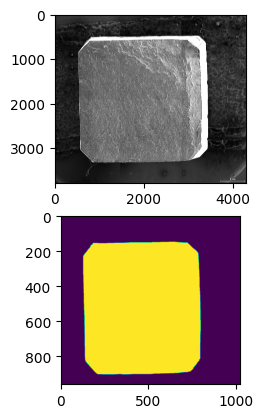

In [75]:
def surface_from_stitched(img_path,input_size = 1024):
    all_points = []
    input_label = []
    image = cv2.resize(cv2.imread(img_path),(input_size,input_size), interpolation = cv2.INTER_AREA)
    if(input_size==1024):
        image = image[0:960,:]
        input_size = 960
    image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
    condition_img = image_blurred>253
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    #Remove reflective edges
    condition_img = image_blurred>253
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    # if len(non_zero_indices[0]) > 0:
    #     for i in range(RANDOM_POSITIONS):
    #         temp_idx = int(random.random()*len(non_zero_indices[0]))
    #         all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
    #         input_label.append(0)

    for x_pos in [len(image_blurred[0])*.65,len(image_blurred[0])*.5,len(image_blurred[0])*.35]:
        for y_pos in [len(image_blurred[1])*.65,len(image_blurred[0])*.5,len(image_blurred[1])*.35]:
            all_points.append([x_pos,y_pos])
            input_label.append(1)

    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=np.array(all_points),
        point_labels=np.array(input_label),
        multimask_output=False,
    )
    processed_mask = (masks[0]).astype(np.uint8) * 255

    # Step 1: Label connected components
    num_labels, labels_im = cv2.connectedComponents(processed_mask)

    # Step 2: Count pixels for each label
    sizes = np.bincount(labels_im.ravel())

    # Step 3: Find the largest component (ignore the background)
    largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

    # Step 4: Create a new mask for the largest component
    largest_defect_mask = np.zeros_like(processed_mask)
    largest_defect_mask[labels_im == largest_component_label] = 255
    processed_mask = largest_defect_mask
    # Creating kernel 
    dilate_kernel = np.ones((6, 6), np.uint8)
    erosion_kernal = np.ones((6, 6), np.uint8)
    # Using cv2.erode() method  
    processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

    # fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
    def fill_mask_holes(mask):
        """
        Fill holes in a binary mask using floodFill.
        
        Parameters:
        mask (numpy.ndarray): Binary input mask (0 and 255 values)
        
        Returns:
        numpy.ndarray: Mask with holes filled
        """
        # Ensure mask is binary and of type uint8
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)
        
        # Threshold to ensure binary image
        _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
        
        # Create a copy of the mask for flood filling
        # Note: floodFill needs a mask that's 2 pixels bigger in each direction
        h, w = binary_mask.shape
        filled_mask = binary_mask.copy()
        filling_mask = np.zeros((h + 2, w + 2), np.uint8)
        
        # Flood fill from point (0,0)
        cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
        
        # Invert the flood-filled image
        filled_mask_inv = cv2.bitwise_not(filled_mask)
        
        # Combine the original mask with the filled holes
        out_mask = binary_mask | filled_mask_inv
        
        return out_mask
    return fill_mask_holes(processed_mask)

path = pd.read_csv(combined_df['path_stitched'].iloc[0])['path'].iloc[0]
print(path)
fig, ax = plt.subplots(2)
ax[0].imshow(cv2.imread(path))
ax[1].imshow(surface_from_stitched(path))
plt.show()

In [101]:
folder_path = "/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/SAM_whole_surface"
for idx in range(len(combined_df['path_stitched'])):
    path =pd.read_csv(combined_df['path_stitched'].iloc[idx])['path'].iloc[0]
    img = cv2.imread(path)
    resulting_path = folder_path+'/'+str(combined_df['Sample#'].iloc[idx])+'.png'
    print(resulting_path)
    cv2.imwrite(resulting_path,surface_from_stitched(img))

/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/SAM_whole_surface/CMU1-3-2.png


TypeError: Can't convert object to 'str' for 'filename'